# Evaluate YOLO v4 on Inferentia

## Introduction
This tutorial walks through compiling and evaluating YOLO v4 model implemented in PyTorch on Inferentia. 

The tutorial has five main sections:

1. Define YOLO v4 model in PyTorch
2. Download the COCO 2017 evaluation dataset and define the data loader function
3. Build, Compile, and Save Neuron-Optimized YOLO v4 TorchScript
4. Evaluate Accuracy on the COCO 2017 Dataset
5. Benchmark COCO Dataset Performance of the Neuron-Optimized TorchScript

Verify that this Jupyter notebook is running the Python kernel environment that was set up according to the [PyTorch Installation Guide](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-intro/pytorch-setup/pytorch-install.html). You can select the kernel from the "Kernel -> Change Kernel" option on the top of this Jupyter notebook page.

## Install Dependencies:
This tutorial requires the following pip packages:

- `torch-neuron`
- `torchvision`
- `pillow`
- `pycocotools`
- `neuron-cc[tensorflow]`

Many of these packages will be installed by default when configuring your environment using the Neuron PyTorch setup guide. The additional dependencies must be installed here.

In [1]:
# !pip install --upgrade pillow pycocotools

## Part 1: Define YOLO v4 model in PyTorch 
The following PyTorch model definition is from https://github.com/Tianxiaomo/pytorch-YOLOv4/.

In [1]:
import numpy as np
import torch
# import torch.neuron
from torch import nn
import torch.nn.functional as F
import os
import warnings

# Setting up NeuronCore groups for inf1.6xlarge with 16 cores
n_cores = 16 # This value should be 4 on inf1.xlarge and inf1.2xlarge
nc_env = ','.join(['1'] * n_cores)
warnings.warn("NEURONCORE_GROUP_SIZES is being deprecated, if your application is using NEURONCORE_GROUP_SIZES please \
see https://awsdocs-neuron.readthedocs-hosted.com/en/latest/release-notes/deprecation.html#announcing-end-of-support-for-neuroncore-group-sizes \
for more details.", DeprecationWarning)
os.environ['NEURONCORE_GROUP_SIZES'] = nc_env


class Mish(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = x * (torch.tanh(torch.nn.functional.softplus(x)))
        return x


class Upsample(nn.Module):
    def __init__(self):
        super(Upsample, self).__init__()

    def forward(self, x, target_size, inference=False):
        assert (x.data.dim() == 4)

        if inference:

            return x.view(x.size(0), x.size(1), x.size(2), 1, x.size(3), 1).\
                    expand(x.size(0), x.size(1), x.size(2), target_size[2] // x.size(2), x.size(3), target_size[3] // x.size(3)).\
                    contiguous().view(x.size(0), x.size(1), target_size[2], target_size[3])
        else:
            return F.interpolate(x, size=(target_size[2], target_size[3]), mode='nearest')


class Conv_Bn_Activation(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, activation, bn=True, bias=False):
        super().__init__()
        pad = (kernel_size - 1) // 2

        self.conv = nn.ModuleList()
        if bias:
            self.conv.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad))
        else:
            self.conv.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad, bias=False))
        if bn:
            self.conv.append(nn.BatchNorm2d(out_channels))
        if activation == "mish":
            self.conv.append(Mish())
        elif activation == "relu":
            self.conv.append(nn.ReLU(inplace=True))
        elif activation == "leaky":
            self.conv.append(nn.LeakyReLU(0.1, inplace=True))
        elif activation == "linear":
            pass
        else:
            print("activate error !!! {} {} {}".format(sys._getframe().f_code.co_filename,
                                                       sys._getframe().f_code.co_name, sys._getframe().f_lineno))

    def forward(self, x):
        for l in self.conv:
            x = l(x)
        return x


class ResBlock(nn.Module):
    """
    Sequential residual blocks each of which consists of \
    two convolution layers.
    Args:
        ch (int): number of input and output channels.
        nblocks (int): number of residual blocks.
        shortcut (bool): if True, residual tensor addition is enabled.
    """

    def __init__(self, ch, nblocks=1, shortcut=True):
        super().__init__()
        self.shortcut = shortcut
        self.module_list = nn.ModuleList()
        for i in range(nblocks):
            resblock_one = nn.ModuleList()
            resblock_one.append(Conv_Bn_Activation(ch, ch, 1, 1, 'mish'))
            resblock_one.append(Conv_Bn_Activation(ch, ch, 3, 1, 'mish'))
            self.module_list.append(resblock_one)

    def forward(self, x):
        for module in self.module_list:
            h = x
            for res in module:
                h = res(h)
            x = x + h if self.shortcut else h
        return x


class DownSample1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv_Bn_Activation(3, 32, 3, 1, 'mish')

        self.conv2 = Conv_Bn_Activation(32, 64, 3, 2, 'mish')
        self.conv3 = Conv_Bn_Activation(64, 64, 1, 1, 'mish')
        # [route]
        # layers = -2
        self.conv4 = Conv_Bn_Activation(64, 64, 1, 1, 'mish')

        self.conv5 = Conv_Bn_Activation(64, 32, 1, 1, 'mish')
        self.conv6 = Conv_Bn_Activation(32, 64, 3, 1, 'mish')
        # [shortcut]
        # from=-3
        # activation = linear

        self.conv7 = Conv_Bn_Activation(64, 64, 1, 1, 'mish')
        # [route]
        # layers = -1, -7
        self.conv8 = Conv_Bn_Activation(128, 64, 1, 1, 'mish')

    def forward(self, input):
        x1 = self.conv1(input)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        # route -2
        x4 = self.conv4(x2)
        x5 = self.conv5(x4)
        x6 = self.conv6(x5)
        # shortcut -3
        x6 = x6 + x4

        x7 = self.conv7(x6)
        # [route]
        # layers = -1, -7
        x7 = torch.cat([x7, x3], dim=1)
        x8 = self.conv8(x7)
        return x8


class DownSample2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv_Bn_Activation(64, 128, 3, 2, 'mish')
        self.conv2 = Conv_Bn_Activation(128, 64, 1, 1, 'mish')
        # r -2
        self.conv3 = Conv_Bn_Activation(128, 64, 1, 1, 'mish')

        self.resblock = ResBlock(ch=64, nblocks=2)

        # s -3
        self.conv4 = Conv_Bn_Activation(64, 64, 1, 1, 'mish')
        # r -1 -10
        self.conv5 = Conv_Bn_Activation(128, 128, 1, 1, 'mish')

    def forward(self, input):
        x1 = self.conv1(input)
        x2 = self.conv2(x1)
        x3 = self.conv3(x1)

        r = self.resblock(x3)
        x4 = self.conv4(r)

        x4 = torch.cat([x4, x2], dim=1)
        x5 = self.conv5(x4)
        return x5


class DownSample3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv_Bn_Activation(128, 256, 3, 2, 'mish')
        self.conv2 = Conv_Bn_Activation(256, 128, 1, 1, 'mish')
        self.conv3 = Conv_Bn_Activation(256, 128, 1, 1, 'mish')

        self.resblock = ResBlock(ch=128, nblocks=8)
        self.conv4 = Conv_Bn_Activation(128, 128, 1, 1, 'mish')
        self.conv5 = Conv_Bn_Activation(256, 256, 1, 1, 'mish')

    def forward(self, input):
        x1 = self.conv1(input)
        x2 = self.conv2(x1)
        x3 = self.conv3(x1)

        r = self.resblock(x3)
        x4 = self.conv4(r)

        x4 = torch.cat([x4, x2], dim=1)
        x5 = self.conv5(x4)
        return x5


class DownSample4(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv_Bn_Activation(256, 512, 3, 2, 'mish')
        self.conv2 = Conv_Bn_Activation(512, 256, 1, 1, 'mish')
        self.conv3 = Conv_Bn_Activation(512, 256, 1, 1, 'mish')

        self.resblock = ResBlock(ch=256, nblocks=8)
        self.conv4 = Conv_Bn_Activation(256, 256, 1, 1, 'mish')
        self.conv5 = Conv_Bn_Activation(512, 512, 1, 1, 'mish')

    def forward(self, input):
        x1 = self.conv1(input)
        x2 = self.conv2(x1)
        x3 = self.conv3(x1)

        r = self.resblock(x3)
        x4 = self.conv4(r)

        x4 = torch.cat([x4, x2], dim=1)
        x5 = self.conv5(x4)
        return x5


class DownSample5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv_Bn_Activation(512, 1024, 3, 2, 'mish')
        self.conv2 = Conv_Bn_Activation(1024, 512, 1, 1, 'mish')
        self.conv3 = Conv_Bn_Activation(1024, 512, 1, 1, 'mish')

        self.resblock = ResBlock(ch=512, nblocks=4)
        self.conv4 = Conv_Bn_Activation(512, 512, 1, 1, 'mish')
        self.conv5 = Conv_Bn_Activation(1024, 1024, 1, 1, 'mish')

    def forward(self, input):
        x1 = self.conv1(input)
        x2 = self.conv2(x1)
        x3 = self.conv3(x1)

        r = self.resblock(x3)
        x4 = self.conv4(r)

        x4 = torch.cat([x4, x2], dim=1)
        x5 = self.conv5(x4)
        return x5


class Neck(nn.Module):
    def __init__(self, inference=False):
        super().__init__()
        self.inference = inference

        self.conv1 = Conv_Bn_Activation(1024, 512, 1, 1, 'leaky')
        self.conv2 = Conv_Bn_Activation(512, 1024, 3, 1, 'leaky')
        self.conv3 = Conv_Bn_Activation(1024, 512, 1, 1, 'leaky')
        # SPP
        self.maxpool1 = nn.MaxPool2d(kernel_size=5, stride=1, padding=5 // 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=9, stride=1, padding=9 // 2)
        self.maxpool3 = nn.MaxPool2d(kernel_size=13, stride=1, padding=13 // 2)

        # R -1 -3 -5 -6
        # SPP
        self.conv4 = Conv_Bn_Activation(2048, 512, 1, 1, 'leaky')
        self.conv5 = Conv_Bn_Activation(512, 1024, 3, 1, 'leaky')
        self.conv6 = Conv_Bn_Activation(1024, 512, 1, 1, 'leaky')
        self.conv7 = Conv_Bn_Activation(512, 256, 1, 1, 'leaky')
        # UP
        self.upsample1 = Upsample()
        # R 85
        self.conv8 = Conv_Bn_Activation(512, 256, 1, 1, 'leaky')
        # R -1 -3
        self.conv9 = Conv_Bn_Activation(512, 256, 1, 1, 'leaky')
        self.conv10 = Conv_Bn_Activation(256, 512, 3, 1, 'leaky')
        self.conv11 = Conv_Bn_Activation(512, 256, 1, 1, 'leaky')
        self.conv12 = Conv_Bn_Activation(256, 512, 3, 1, 'leaky')
        self.conv13 = Conv_Bn_Activation(512, 256, 1, 1, 'leaky')
        self.conv14 = Conv_Bn_Activation(256, 128, 1, 1, 'leaky')
        # UP
        self.upsample2 = Upsample()
        # R 54
        self.conv15 = Conv_Bn_Activation(256, 128, 1, 1, 'leaky')
        # R -1 -3
        self.conv16 = Conv_Bn_Activation(256, 128, 1, 1, 'leaky')
        self.conv17 = Conv_Bn_Activation(128, 256, 3, 1, 'leaky')
        self.conv18 = Conv_Bn_Activation(256, 128, 1, 1, 'leaky')
        self.conv19 = Conv_Bn_Activation(128, 256, 3, 1, 'leaky')
        self.conv20 = Conv_Bn_Activation(256, 128, 1, 1, 'leaky')

    def forward(self, input, downsample4, downsample3, inference=False):
        x1 = self.conv1(input)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        # SPP
        m1 = self.maxpool1(x3)
        m2 = self.maxpool2(x3)
        m3 = self.maxpool3(x3)
        spp = torch.cat([m3, m2, m1, x3], dim=1)
        # SPP end
        x4 = self.conv4(spp)
        x5 = self.conv5(x4)
        x6 = self.conv6(x5)
        x7 = self.conv7(x6)
        # UP
        up = self.upsample1(x7, downsample4.size(), self.inference)
        # R 85
        x8 = self.conv8(downsample4)
        # R -1 -3
        x8 = torch.cat([x8, up], dim=1)

        x9 = self.conv9(x8)
        x10 = self.conv10(x9)
        x11 = self.conv11(x10)
        x12 = self.conv12(x11)
        x13 = self.conv13(x12)
        x14 = self.conv14(x13)

        # UP
        up = self.upsample2(x14, downsample3.size(), self.inference)
        # R 54
        x15 = self.conv15(downsample3)
        # R -1 -3
        x15 = torch.cat([x15, up], dim=1)

        x16 = self.conv16(x15)
        x17 = self.conv17(x16)
        x18 = self.conv18(x17)
        x19 = self.conv19(x18)
        x20 = self.conv20(x19)
        return x20, x13, x6


class Yolov4Head(nn.Module):
    def __init__(self, output_ch, n_classes, inference=False):
        super().__init__()
        self.inference = inference

        self.conv1 = Conv_Bn_Activation(128, 256, 3, 1, 'leaky')
        self.conv2 = Conv_Bn_Activation(256, output_ch, 1, 1, 'linear', bn=False, bias=True)

        self.yolo1 = YoloLayer(
                                anchor_mask=[0, 1, 2], num_classes=n_classes,
                                anchors=[12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401],
                                num_anchors=9, stride=8)

        # R -4
        self.conv3 = Conv_Bn_Activation(128, 256, 3, 2, 'leaky')

        # R -1 -16
        self.conv4 = Conv_Bn_Activation(512, 256, 1, 1, 'leaky')
        self.conv5 = Conv_Bn_Activation(256, 512, 3, 1, 'leaky')
        self.conv6 = Conv_Bn_Activation(512, 256, 1, 1, 'leaky')
        self.conv7 = Conv_Bn_Activation(256, 512, 3, 1, 'leaky')
        self.conv8 = Conv_Bn_Activation(512, 256, 1, 1, 'leaky')
        self.conv9 = Conv_Bn_Activation(256, 512, 3, 1, 'leaky')
        self.conv10 = Conv_Bn_Activation(512, output_ch, 1, 1, 'linear', bn=False, bias=True)
        
        self.yolo2 = YoloLayer(
                                anchor_mask=[3, 4, 5], num_classes=n_classes,
                                anchors=[12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401],
                                num_anchors=9, stride=16)

        # R -4
        self.conv11 = Conv_Bn_Activation(256, 512, 3, 2, 'leaky')

        # R -1 -37
        self.conv12 = Conv_Bn_Activation(1024, 512, 1, 1, 'leaky')
        self.conv13 = Conv_Bn_Activation(512, 1024, 3, 1, 'leaky')
        self.conv14 = Conv_Bn_Activation(1024, 512, 1, 1, 'leaky')
        self.conv15 = Conv_Bn_Activation(512, 1024, 3, 1, 'leaky')
        self.conv16 = Conv_Bn_Activation(1024, 512, 1, 1, 'leaky')
        self.conv17 = Conv_Bn_Activation(512, 1024, 3, 1, 'leaky')
        self.conv18 = Conv_Bn_Activation(1024, output_ch, 1, 1, 'linear', bn=False, bias=True)
        
        self.yolo3 = YoloLayer(
                                anchor_mask=[6, 7, 8], num_classes=n_classes,
                                anchors=[12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401],
                                num_anchors=9, stride=32)

    def forward(self, input1, input2, input3):
        x1 = self.conv1(input1)
        x2 = self.conv2(x1)

        x3 = self.conv3(input1)
        # R -1 -16
        x3 = torch.cat([x3, input2], dim=1)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)
        x6 = self.conv6(x5)
        x7 = self.conv7(x6)
        x8 = self.conv8(x7)
        x9 = self.conv9(x8)
        x10 = self.conv10(x9)

        # R -4
        x11 = self.conv11(x8)
        # R -1 -37
        x11 = torch.cat([x11, input3], dim=1)

        x12 = self.conv12(x11)
        x13 = self.conv13(x12)
        x14 = self.conv14(x13)
        x15 = self.conv15(x14)
        x16 = self.conv16(x15)
        x17 = self.conv17(x16)
        x18 = self.conv18(x17)
        
        if self.inference:
            y1 = self.yolo1(x2)
            y2 = self.yolo2(x10)
            y3 = self.yolo3(x18)

            return get_region_boxes([y1, y2, y3])
        
        else:
            return [x2, x10, x18]


class Yolov4(nn.Module):
    def __init__(self, yolov4conv137weight=None, n_classes=80, inference=False):
        super().__init__()

        output_ch = (4 + 1 + n_classes) * 3

        # backbone
        self.down1 = DownSample1()
        self.down2 = DownSample2()
        self.down3 = DownSample3()
        self.down4 = DownSample4()
        self.down5 = DownSample5()
        # neck
        self.neek = Neck(inference)
        # yolov4conv137
        if yolov4conv137weight:
            _model = nn.Sequential(self.down1, self.down2, self.down3, self.down4, self.down5, self.neek)
            pretrained_dict = torch.load(yolov4conv137weight)

            model_dict = _model.state_dict()
            # 1. filter out unnecessary keys
            pretrained_dict = {k1: v for (k, v), k1 in zip(pretrained_dict.items(), model_dict)}
            # 2. overwrite entries in the existing state dict
            model_dict.update(pretrained_dict)
            _model.load_state_dict(model_dict)
        
        # head
        self.head = Yolov4Head(output_ch, n_classes, inference)


    def forward(self, input):
        d1 = self.down1(input)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)

        x20, x13, x6 = self.neek(d5, d4, d3)

        output = self.head(x20, x13, x6)
        return output


def yolo_forward_dynamic(output, conf_thresh, num_classes, anchors, num_anchors, scale_x_y, only_objectness=1,
                              validation=False):
    # Output would be invalid if it does not satisfy this assert
    # assert (output.size(1) == (5 + num_classes) * num_anchors)

    # print(output.size())

    # Slice the second dimension (channel) of output into:
    # [ 2, 2, 1, num_classes, 2, 2, 1, num_classes, 2, 2, 1, num_classes ]
    # And then into
    # bxy = [ 6 ] bwh = [ 6 ] det_conf = [ 3 ] cls_conf = [ num_classes * 3 ]
    # batch = output.size(0)
    # H = output.size(2)
    # W = output.size(3)

    bxy_list = []
    bwh_list = []
    det_confs_list = []
    cls_confs_list = []

    for i in range(num_anchors):
        begin = i * (5 + num_classes)
        end = (i + 1) * (5 + num_classes)
        
        bxy_list.append(output[:, begin : begin + 2])
        bwh_list.append(output[:, begin + 2 : begin + 4])
        det_confs_list.append(output[:, begin + 4 : begin + 5])
        cls_confs_list.append(output[:, begin + 5 : end])

    # Shape: [batch, num_anchors * 2, H, W]
    bxy = torch.cat(bxy_list, dim=1)
    # Shape: [batch, num_anchors * 2, H, W]
    bwh = torch.cat(bwh_list, dim=1)

    # Shape: [batch, num_anchors, H, W]
    det_confs = torch.cat(det_confs_list, dim=1)
    # Shape: [batch, num_anchors * H * W]
    det_confs = det_confs.view(output.size(0), num_anchors * output.size(2) * output.size(3))

    # Shape: [batch, num_anchors * num_classes, H, W]
    cls_confs = torch.cat(cls_confs_list, dim=1)
    # Shape: [batch, num_anchors, num_classes, H * W]
    cls_confs = cls_confs.view(output.size(0), num_anchors, num_classes, output.size(2) * output.size(3))
    # Shape: [batch, num_anchors, num_classes, H * W] --> [batch, num_anchors * H * W, num_classes] 
    cls_confs = cls_confs.permute(0, 1, 3, 2).reshape(output.size(0), num_anchors * output.size(2) * output.size(3), num_classes)

    # Apply sigmoid(), exp() and softmax() to slices
    #
    bxy = torch.sigmoid(bxy) * scale_x_y - 0.5 * (scale_x_y - 1)
    bwh = torch.exp(bwh)
    det_confs = torch.sigmoid(det_confs)
    cls_confs = torch.sigmoid(cls_confs)

    # Prepare C-x, C-y, P-w, P-h (None of them are torch related)
    grid_x = np.expand_dims(np.expand_dims(np.expand_dims(np.linspace(0, output.size(3) - 1, output.size(3)), axis=0).repeat(output.size(2), 0), axis=0), axis=0)
    grid_y = np.expand_dims(np.expand_dims(np.expand_dims(np.linspace(0, output.size(2) - 1, output.size(2)), axis=1).repeat(output.size(3), 1), axis=0), axis=0)
    # grid_x = torch.linspace(0, W - 1, W).reshape(1, 1, 1, W).repeat(1, 1, H, 1)
    # grid_y = torch.linspace(0, H - 1, H).reshape(1, 1, H, 1).repeat(1, 1, 1, W)

    anchor_w = []
    anchor_h = []
    for i in range(num_anchors):
        anchor_w.append(anchors[i * 2])
        anchor_h.append(anchors[i * 2 + 1])

    device = None
    cuda_check = output.is_cuda
    if cuda_check:
        device = output.get_device()

    bx_list = []
    by_list = []
    bw_list = []
    bh_list = []

    # Apply C-x, C-y, P-w, P-h
    for i in range(num_anchors):
        ii = i * 2
        # Shape: [batch, 1, H, W]
        bx = bxy[:, ii : ii + 1] + torch.tensor(grid_x, device=device, dtype=torch.float32) # grid_x.to(device=device, dtype=torch.float32)
        # Shape: [batch, 1, H, W]
        by = bxy[:, ii + 1 : ii + 2] + torch.tensor(grid_y, device=device, dtype=torch.float32) # grid_y.to(device=device, dtype=torch.float32)
        # Shape: [batch, 1, H, W]
        bw = bwh[:, ii : ii + 1] * anchor_w[i]
        # Shape: [batch, 1, H, W]
        bh = bwh[:, ii + 1 : ii + 2] * anchor_h[i]

        bx_list.append(bx)
        by_list.append(by)
        bw_list.append(bw)
        bh_list.append(bh)


    ########################################
    #   Figure out bboxes from slices     #
    ########################################
    
    # Shape: [batch, num_anchors, H, W]
    bx = torch.cat(bx_list, dim=1)
    # Shape: [batch, num_anchors, H, W]
    by = torch.cat(by_list, dim=1)
    # Shape: [batch, num_anchors, H, W]
    bw = torch.cat(bw_list, dim=1)
    # Shape: [batch, num_anchors, H, W]
    bh = torch.cat(bh_list, dim=1)

    # Shape: [batch, 2 * num_anchors, H, W]
    bx_bw = torch.cat((bx, bw), dim=1)
    # Shape: [batch, 2 * num_anchors, H, W]
    by_bh = torch.cat((by, bh), dim=1)

    # normalize coordinates to [0, 1]
    bx_bw /= output.size(3)
    by_bh /= output.size(2)

    # Shape: [batch, num_anchors * H * W, 1]
    bx = bx_bw[:, :num_anchors].view(output.size(0), num_anchors * output.size(2) * output.size(3), 1)
    by = by_bh[:, :num_anchors].view(output.size(0), num_anchors * output.size(2) * output.size(3), 1)
    bw = bx_bw[:, num_anchors:].view(output.size(0), num_anchors * output.size(2) * output.size(3), 1)
    bh = by_bh[:, num_anchors:].view(output.size(0), num_anchors * output.size(2) * output.size(3), 1)

    bx1 = bx - bw * 0.5
    by1 = by - bh * 0.5
    bx2 = bx1 + bw
    by2 = by1 + bh

    # Shape: [batch, num_anchors * h * w, 4] -> [batch, num_anchors * h * w, 1, 4]
    boxes = torch.cat((bx1, by1, bx2, by2), dim=2).view(output.size(0), num_anchors * output.size(2) * output.size(3), 1, 4)
    # boxes = boxes.repeat(1, 1, num_classes, 1)

    # boxes:     [batch, num_anchors * H * W, 1, 4]
    # cls_confs: [batch, num_anchors * H * W, num_classes]
    # det_confs: [batch, num_anchors * H * W]

    det_confs = det_confs.view(output.size(0), num_anchors * output.size(2) * output.size(3), 1)
    confs = cls_confs * det_confs

    # boxes: [batch, num_anchors * H * W, 1, 4]
    # confs: [batch, num_anchors * H * W, num_classes]

    return  boxes, confs

class YoloLayer(nn.Module):
    """
    Yolo layer
    model_out: while inference,is post-processing inside or outside the model
        true:outside
    """
    def __init__(self, anchor_mask=[], num_classes=0, anchors=[], num_anchors=1, stride=32, model_out=False):
        super(YoloLayer, self).__init__()
        self.anchor_mask = anchor_mask
        self.num_classes = num_classes
        self.anchors = anchors
        self.num_anchors = num_anchors
        self.anchor_step = len(anchors) // num_anchors
        self.coord_scale = 1
        self.noobject_scale = 1
        self.object_scale = 5
        self.class_scale = 1
        self.thresh = 0.6
        self.stride = stride
        self.seen = 0
        self.scale_x_y = 1

        self.model_out = model_out

    def forward(self, output, target=None):
        if self.training:
            return output
        masked_anchors = []
        for m in self.anchor_mask:
            masked_anchors += self.anchors[m * self.anchor_step:(m + 1) * self.anchor_step]
        masked_anchors = [anchor / self.stride for anchor in masked_anchors]

        return yolo_forward_dynamic(output, self.thresh, self.num_classes, masked_anchors, len(self.anchor_mask),scale_x_y=self.scale_x_y)


def get_region_boxes(boxes_and_confs):

    # print('Getting boxes from boxes and confs ...')

    boxes_list = []
    confs_list = []

    for item in boxes_and_confs:
        boxes_list.append(item[0])
        confs_list.append(item[1])

    # boxes: [batch, num1 + num2 + num3, 1, 4]
    # confs: [batch, num1 + num2 + num3, num_classes]
    boxes = torch.cat(boxes_list, dim=1)
    confs = torch.cat(confs_list, dim=1)
        
    return boxes, confs

/home/jo/yolov4_torch/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: NEURONCORE_GROUP_SIZES is being deprecated, if your application is using NEURONCORE_GROUP_SIZES please see https://awsdocs-neuron.readthedocs-hosted.com/en/latest/release-notes/deprecation.html#announcing-end-of-support-for-neuroncore-group-sizes for more details.
  


## Part 2: Download the COCO 2017 evaluation dataset and define the data loader function

### Download dataset

In [2]:
# !curl -LO http://images.cocodataset.org/zips/val2017.zip
# !curl -LO http://images.cocodataset.org/annotations/annotations_trainval2017.zip


In [3]:
# !unzip -q val2017.zip
# !unzip annotations_trainval2017.zip

In [4]:
!ls

INTERRUPTED.pth		      log	   val2017.zip
annotations		      notes.ipynb  yolo_v4.ipynb
annotations_trainval2017.zip  val2017	   yolo_v4.pth


### Define data loader

In [5]:
import os
import json
import time
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset
from pycocotools.coco import COCO


def get_image_filenames(root=os.getcwd()):
    """
    Generate paths to the coco dataset image files.
    
    Args:
        root (str): The root folder contains.
    
    Yields:
        filename (str): The path to an image file.
    """
    image_path = os.path.join(root, 'val2017')
    for root, dirs, files in os.walk(image_path):
        for filename in files:
            yield os.path.join(image_path, filename)

            
def get_coco_dataloader(coco2017_root, transform, subset_indices=None):
    """
    Create the dataset loader and ground truth coco dataset.
    
    Arguments:
        coco2017_root (str): The root directory to load the data/labels from.
        transform (torchvision.Transform): A transform to apply to the images.
        subset_indices (list): Indices used to create a subset of the dataset.

    Returns: 
        loader (iterable): Produces transformed images and labels.
        cocoGt (pycocotools.coco.COCO): Contains the ground truth in coco 
            format.
        label_info (dict): A mapping from label id to the human-readable name.
    """

    # Create the dataset
    coco2017_img_path = os.path.join(coco2017_root, 'val2017')
    coco2017_ann_path = os.path.join(
        coco2017_root, 'annotations/instances_val2017.json')

    # check the number of images in val2017 - Should be 5000
    num_files = len(list(get_image_filenames(coco2017_root)))
    print('\nNumber of images in val2017 = {}\n'.format(num_files))

    # load annotations to decode classification results
    with open(coco2017_ann_path) as f:
        annotate_json = json.load(f)
    label_info = {label["id"]: label["name"]
                  for label in annotate_json['categories']}

    # initialize COCO ground truth dataset
    cocoGt = COCO(coco2017_ann_path)

    # create the dataset using torchvision's coco detection dataset
    coco_val_data = dset.CocoDetection(
        root=coco2017_img_path, 
        annFile=coco2017_ann_path, 
        transform=transform
    )

    if subset_indices is not None:
        # Create a smaller subset of the data for testing - e.g. to pinpoint error at image 516
        coco_val_data = torch.utils.data.Subset(coco_val_data, subset_indices)

    # create the dataloader using torch dataloader
    loader = torch.utils.data.DataLoader(coco_val_data, batch_size=1, shuffle=False)

    return loader, cocoGt, label_info


### Load dataset
Here 2 dataset loaders are created and the resulting data is displayed
- `orig_coco_val_data_loader`: Contains the original unmodified image
- `coco_val_data_loader`: Contains images of a standardized size of 608x608 pixels 

In [6]:
# coco2017_root = './'
# orig_coco_val_data_loader, *_ = get_coco_dataloader(coco2017_root, transforms.ToTensor())
# transform = transforms.Compose([transforms.Resize([608, 608]), transforms.ToTensor()])
# coco_val_data_loader, cocoGt, label_info = get_coco_dataloader(coco2017_root, transform)
# image_orig, _ = next(iter(orig_coco_val_data_loader))
# print(image_orig.shape)
# image, image_info = next(iter(coco_val_data_loader))
# image_id = image_info[0]["image_id"].item()
# print(image.shape)

### Define some helper functions for deployment (inference)

In [7]:
def postprocess(boxes, scores, score_threshold=0.05, iou_threshold=0.5):
    """
    Classifies and filters bounding boxes from Yolo V4 output.
    
    Performs classification, filtering, and non-maximum suppression to remove
    boxes that are irrelevant. The result is the filtered set of boxes, the 
    associated label confidence score, and the predicted label.
    
    See: https://pytorch.org/docs/stable/torchvision/ops.html#torchvision.ops.nms
    
    Args:
        boxes (torch.Tensor): The Yolo V4 bounding boxes.
        scores (torch.Tensor): The categories scores for each box.
        score_threshold (float): Ignore boxes with scores below threshold.
        iou_threshold (float): Discards boxes with intersection above threshold. 
            
    Returns:
        boxes (torch.Tensor): The filtered Yolo V4 bounding boxes.
        scores (torch.Tensor): The label score for each box.
        labels (torch.Tensor): The label for each box.
    """
    
    # shape: [n_batch, n_boxes, 1, 4] => [n_boxes, 4]  # Assumes n_batch size is 1
    boxes = boxes.squeeze()

    # shape: [n_batch, n_boxes, 80] => [n_boxes, 80]  # Assumes n_batch size is 1
    scores = scores.squeeze(dim=0)

    # Classify each box according to the maximum category score
    score, column = torch.max(scores, dim=1)

    # Filter out rows for scores which are below threshold
    mask = score > score_threshold

    # Filter model output data
    boxes = boxes[mask]
    score = score[mask]
    idxs = column[mask]

    # Perform non-max suppression on all categories at once. shape: [n_keep,]
    keep = torchvision.ops.batched_nms(
        boxes=boxes, 
        scores=score, 
        idxs=idxs,
        iou_threshold=iou_threshold,
    )

    # The image category id associated with each column
    categories = torch.tensor([
        1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31,
        32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
        44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
        57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72,
        73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85,
        86, 87, 88, 89, 90
    ])
    
    boxes = boxes[keep]       # shape: [n_keep, 4]
    score = score[keep]       # shape: [n_keep,]
    idxs = idxs[keep]
    label = categories[idxs]  # shape: [n_keep,]
    
    return boxes, score, label


def get_results_as_dict(boxes, scores, labels, image_orig):
    """
    Transforms post-processed output into dictionary output.
    
    This translates the model coordinate bounding boxes (x1, y1, x2, y2) 
    into a rectangular description (x, y, width, height) scaled to the 
    original image size.
    
    Args:
        boxes (torch.Tensor): The Yolo V4 bounding boxes.
        scores (torch.Tensor): The label score for each box.
        labels (torch.Tensor): The label for each box.
        image_orig (torch.Tensor): The image to scale the bounding boxes to.
        
    Returns:
        output (dict): The dictionary of rectangle bounding boxes.
    """
    h_size, w_size = image_orig.shape[-2:]

    x1 = boxes[:, 0] * w_size
    y1 = boxes[:, 1] * h_size
    x2 = boxes[:, 2] * w_size
    y2 = boxes[:, 3] * h_size

    width = x2 - x1
    height = y2 - y1

    boxes = torch.stack([x1, y1, width, height]).T
    return {
        'boxes': boxes.detach().numpy(),
        'labels': labels.detach().numpy(),
        'scores': scores.detach().numpy(),
    }


def prepare_for_coco_detection(predictions):
    """
    Convert dictionary model predictions into an expected COCO dataset format.
    
    Args:
        predictions (dict): The list of box coordinates, scores, and labels.
        
    Returns:
        output (list[dict]): The list of bounding boxes.
    """
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"].tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

### Download pretrained checkpoint

In [8]:
# import requests

# def download_file_from_google_drive(id, destination):
#     data = {'export': 'download', 'confirm': 't'}
#     response = requests.post('https://drive.google.com/uc?id=1wv_LiFeCRYwtpkqREPeI13-gPELBDwuJ', data=data)
#     save_response_content(response, destination)

# def save_response_content(response, destination):
#     CHUNK_SIZE = 32768
#     with open(destination, "wb") as f:
#         for chunk in response.iter_content(CHUNK_SIZE):
#             if chunk:  # filter out keep-alive new chunks
#                 f.write(chunk)

In [9]:
# download_file_from_google_drive('1wv_LiFeCRYwtpkqREPeI13-gPELBDwuJ', './yolo_v4.pth')

## Part 3: Build, Compile, and Save Neuron-Optimized YOLO v4 TorchScript
### Construct model and load pretrained checkpoint

In [10]:
model = Yolov4(yolov4conv137weight=None, n_classes=1, inference=True)
# weightfile = "./yolo_v4.pth"
weightfile = "/home/jo/pytorch-YOLOv4/checkpoints/Yolov4_epoch200.pth"
pretrained_dict = torch.load(weightfile, map_location=torch.device('cuda'))

model.load_state_dict(pretrained_dict, strict=False)
model.eval()

Yolov4(
  (down1): DownSample1(
    (conv1): Conv_Bn_Activation(
      (conv): ModuleList(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (conv2): Conv_Bn_Activation(
      (conv): ModuleList(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (conv3): Conv_Bn_Activation(
      (conv): ModuleList(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (conv4): Conv_Bn_Activation(
      (conv): ModuleList(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNo

### Execute inference for a single image and display output

In [11]:
from PIL import Image
import torchvision.transforms as transforms
# READ IMAGE
image_path = "/home/jo/pytorch-YOLOv4/custom_data/images/im_2.jpeg"
image_sample =  Image.open(image_path)
# DEFINE TRANSFORMS
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])
preprocessing = transforms.ToTensor()
image = preprocessing(image_sample)

torch.Size([1, 22743, 1, 4])
torch.Size([1, 22743, 1])


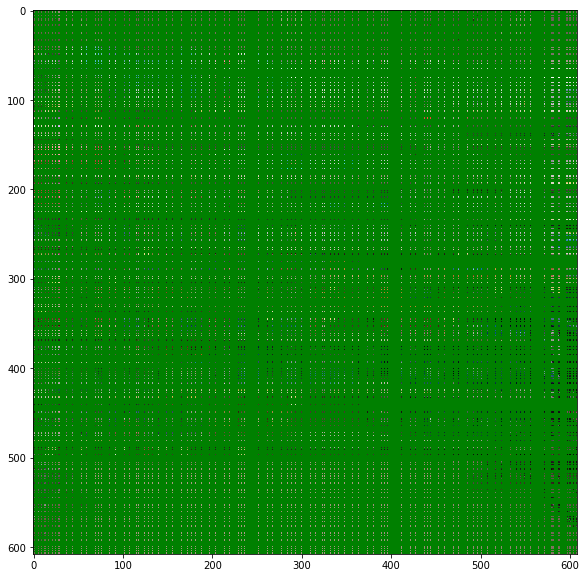

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# image_orig, _ = next(iter(orig_coco_val_data_loader))

# ## the scale of image is from 0 to 1

# image, _ = next(iter(coco_val_data_loader))


image = image.unsqueeze(0)

boxes, scores = model(image)
print((boxes.size()))
print((scores.size()))


boxes, scores, labels = postprocess(boxes, scores)
result_dict = get_results_as_dict(boxes, scores, labels, image)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image.numpy().squeeze(0).transpose(1, 2, 0))
for xywh, _ in zip(result_dict['boxes'], result_dict['labels']):
    x, y, w, h = xywh
    rect = patches.Rectangle((x, y), w, h, linewidth=0.1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
plt.show()

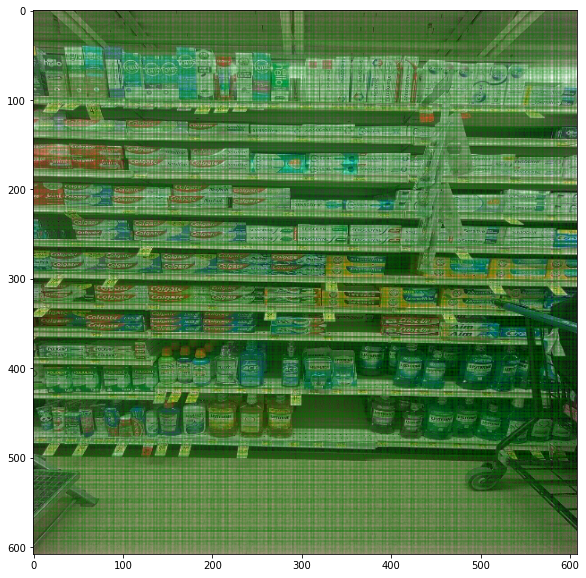

: 

In [14]:
# boxes, scores, labels = postprocess(boxes, scores)
# result_dict = get_results_as_dict(boxes, scores, labels, image)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image.numpy().squeeze(0).transpose(1, 2, 0))
for xywh, _ in zip(result_dict['boxes'], result_dict['labels']):
    x, y, w, h = xywh
    rect = patches.Rectangle((x, y), w, h, linewidth=0.1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
plt.show()

In [10]:
print(torch.__version__)
print(torchvision.__version__)

1.11.0+cu113
0.12.0+cu102


In [ ]:
pip3 install torchvision --extra-index-url https://download.pytorch.org/whl/cu113


In [8]:
# shape: [n_batch, n_boxes, 80] => [n_boxes, 80]  # Assumes n_batch size is 1
scores2 = scores.squeeze()

print(scores2.size())
# Classify each box according to the maximum category score
score, column = torch.max(scores2, dim=1)

torch.Size([22743])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

### Run compilation with manually specified device placement

First, inspect the model without running compilation by adding the `skip_compiler=True` argument to the `torch.neuron.trace` call.

In [11]:
model_neuron_for_inspection = torch.neuron.trace(model, image, skip_compiler=True)
print(model_neuron_for_inspection)

/home/zhuogang/pytorch_neuron_venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
/home/zhuogang/pytorch_neuron_venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:535: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
/home/zhuogang/pytorch_neuron_venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:537: TracerWarning: torch.tensor results are reg

Yolov4(%[2418] : torch.float32(1, 3, 608, 608)):
  DownSample1#7/Conv_Bn_Activation#8/Conv2d#6:
        %[DownSample1#7/Conv_Bn_Activation#8/11] : torch.float32(1, 32, 608, 608) = ./aten::_convolution#20(%[2418])
  DownSample1#7/Conv_Bn_Activation#8/BatchNorm2d#7:
        %[DownSample1#7/Conv_Bn_Activation#8/12] : torch.float32(1, 32, 608, 608) = ./aten::batch_norm#8(%[DownSample1#7/Conv_Bn_Activation#8/11])
  DownSample1#7/Conv_Bn_Activation#8/Mish#8:
        %[./4] : torch.float32(1, 32, 608, 608) = ./aten::softplus#2(%[DownSample1#7/Conv_Bn_Activation#8/12])
        %[./5] : torch.float32(1, 32, 608, 608) = ./aten::tanh#3(%[./4])
        %[DownSample1#7/23] : torch.float32(1, 32, 608, 608) = ./aten::mul#4(%[DownSample1#7/Conv_Bn_Activation#8/12], %[./5])
  DownSample1#7/Conv_Bn_Activation#9/Conv2d#6:
        %[DownSample1#7/Conv_Bn_Activation#9/11] : torch.float32(1, 64, 304, 304) = ./aten::_convolution#20(%[DownSample1#7/23])
  DownSample1#7/Conv_Bn_Activation#9/BatchNorm2d#7:
    

Inspecting the model, we discover that there are many `aten::slice` operations in some submodules called `YoloLayer`. Although these operations are supported by the neuron-cc compiler, they are not going to run efficiently on the Inferentia hardware. To work it around, we recommend to manually place these operators on CPU.

To manually place `YoloLayer` on CPU, we may make use of the `subgraph_builder_function` argument in `torch.neuron.trace`. It is a callback function that returns `True` or `False` based on information available in `node`. The typical use is a condition based on either `node.name` or `node.type_string`.

In [13]:
def subgraph_builder_function(node):
    return 'YoloLayer' not in node.name

# model_neuron = torch.neuron.trace(model, image, subgraph_builder_function=subgraph_builder_function)
# model_neuron.save('yolo_v4_neuron.pt')

/home/zhuogang/pytorch_neuron_venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
/home/zhuogang/pytorch_neuron_venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:535: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
/home/zhuogang/pytorch_neuron_venv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:537: TracerWarning: torch.tensor results are reg

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


INFO:Neuron:Compiling function _NeuronGraph$2738 with neuron-cc
INFO:Neuron:Compiling with command line: '/home/zhuogang/pytorch_neuron_venv3.7/bin/neuron-cc compile /tmp/tmpdbm8xak6/graph_def.pb --framework TENSORFLOW --pipeline compile SaveTemps --output /tmp/tmpdbm8xak6/graph_def.neff --io-config {"inputs": {"0:0": [[1, 3, 608, 608], "float32"]}, "outputs": ["Yolov4Head_14/Conv_Bn_Activation_22/Conv2d_2/aten__convolution/transpose_2:0", "Yolov4Head_14/Conv_Bn_Activation_33/Conv2d_2/aten__convolution/transpose_2:0", "Yolov4Head_14/Conv_Bn_Activation_44/Conv2d_2/aten__convolution/transpose_2:0"]} --verbose 35'


..............
Compiler status PASS


INFO:Neuron:skip_inference_context for tensorboard symbols at /home/zhuogang/pytorch_neuron_venv3.7/lib/python3.7/site-packages/torch_neuron/tensorboard.py:305 tb_parse
INFO:Neuron:Number of neuron graph operations 3965 did not match traced graph 3872 - using heuristic matching of hierarchical information
INFO:Neuron:Number of arithmetic operators (post-compilation) before = 1114, compiled = 572, percent compiled = 51.35%
INFO:Neuron:The neuron partitioner created 1 sub-graphs
INFO:Neuron:Neuron successfully compiled 1 sub-graphs, Total fused subgraphs = 1, Percent of model sub-graphs successfully compiled = 100.0%
INFO:Neuron:Compiled these operators (and operator counts) to Neuron:
INFO:Neuron: => aten::Int: 28
INFO:Neuron: => aten::_convolution: 110
INFO:Neuron: => aten::add: 23
INFO:Neuron: => aten::batch_norm: 107
INFO:Neuron: => aten::cat: 10
INFO:Neuron: => aten::contiguous: 2
INFO:Neuron: => aten::div: 4
INFO:Neuron: => aten::expand: 2
INFO:Neuron: => aten::leaky_relu: 35
INFO:

Compilation is now finished and the compiled model has been saved to a local file called 'yolo_v4_neuron.pt'. Saving is important due to the slow compilation process.

## Part 4: Evaluate Accuracy on the COCO 2017 Dataset
### Load compiled model and run inference
To validate accuracy of the compiled model, lets run inference on the COCO 2017 validation dataset. We start by defining a helper function `run_inference`.

In [14]:
def run_inference(dataloader, dataloader_orig, model, convert=True, modelName=''):
    """
    Run Yolo V4 inference on the COCO dataset.
    
    Args:
        dataloader (iterable): Data loader of input processed images and labels.
        dataloader_orig (iterable): Data loader with original images.
        model (torch.nn.Module): The torch model to run inference against.
        convert (bool): Set to False when using a vanilla torchvision model that 
            does not need to be transformed into coco format.
        
    Returns: 
        imgIds (list): The list of images with predictions.
        cocoDt (pycocotools.coco.COCO): Contains the predictions from the model 
            in coco format.
    """
    print('\n================ Starting Inference on {} Images using {} model ================\n'.format(
        len(dataloader), modelName))

    modelName = str(modelName).replace(" ", "_")

    # convert predicition to cocoDt
    # code from def evaluate in https://github.com/pytorch/vision/blob/master/references/detection/engine.py
    imgIds = []
    results = []
    skippedImages = []

    # time inference
    inference_time = 0.0
    for idx, ((image, targets), (image_orig, _)) in enumerate(zip(dataloader, dataloader_orig)):
        # if target is empty, skip the image because it breaks the scripted model
        if not targets:
            skippedImages.append(idx)
            continue

        # get the predictions
        start_time = time.time()
        boxes, scores = model(image)
        delta = time.time() - start_time
        inference_time += delta
        boxes, scores, labels = postprocess(boxes, scores)
        outputs = get_results_as_dict(boxes, scores, labels, image_orig)

        res = {target["image_id"].item(): output for target,
               output in zip(targets, [outputs])}

        # add the image id to imgIds
        image_id = targets[0]["image_id"].item()
        imgIds.append(image_id)

        # convert the predicition into cocoDt results
        pred = prepare_for_coco_detection(res)
        results.extend(pred)

    print('\n==================== Performance Measurement ====================')
    print('Finished inference on {} images in {:.2f} seconds'.format(
        len(dataloader), inference_time))
    print('=================================================================\n')

    # create bbox detections file
    # following code in https://github.com/aws/aws-neuron-sdk/blob/master/src/examples/tensorflow/yolo_v4_demo/evaluate.ipynb
    resultsfile = modelName + '_bbox_detections.json'
    print('Generating json file...')
    with open(resultsfile, 'w') as f:
        json.dump(results, f)

    # return COCO api object with loadRes
    cocoDt = cocoGt.loadRes(resultsfile)

    return imgIds, cocoDt

The next step is to simply load the compiled model from disk and then run inference.

In [15]:
model_neuron = torch.jit.load('yolo_v4_neuron.pt')

[W runtime.cpp:220] Warning: NEURONCORE_GROUP_SIZES is being deprecated. Please see Neuron documentation for more details. (function initialize)
2022-May-02 21:03:55.0022 10265:10265 ERROR   NRT:nrt_init                                Unable to read compatible Driver version.
2022-May-02 21:03:55.0022 10265:10265 ERROR   NRT:nrt_init                                Please check /dev/neuron# is accessible. If you're using containers, please ensure Neuron Devices are passed to the container by specifying `--device /dev/neuron#`.


RuntimeError: The PyTorch Neuron Runtime could not be initialized. Neuron Driver issues are logged
to your system logs. See the Neuron Runtime's troubleshooting guide for help on this
topic: https://awsdocs-neuron.readthedocs-hosted.com/en/latest/

In [ ]:
imgIds, cocoDt = run_inference(coco_val_data_loader, orig_coco_val_data_loader, model_neuron)

We then use the standard `pycocotools` routines to generate a report of bounding box precision/recall.

In [ ]:
from pycocotools.cocoeval import COCOeval

cocoEval = COCOeval(cocoGt, cocoDt, 'bbox')
cocoEval.params.imgIds = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

For reference, we may perform the same evaluation on the CPU model.

In [ ]:
imgIdsRef, cocoDtRef = run_inference(coco_val_data_loader, orig_coco_val_data_loader, model)

In [ ]:
cocoEval = COCOeval(cocoGt, cocoDtRef, 'bbox')
cocoEval.params.imgIds = imgIdsRef
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

## Part 5: Benchmark COCO Dataset Performance of the Neuron-Optimized TorchScript
The following code snippet sets up data parallel on 16 NeuronCores and runs saturated multi-threaded inference on the Inferentia accelerator. Note that the number of cores (`n_cores`) should be set to the number of available NeuronCores on the current instance.

In [ ]:
import torch
import torch.neuron
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor
import PIL
import os
import time

n_threads = 16

def get_image_filenames(root=os.getcwd()):
    """
    Generate paths to the coco dataset image files.
    
    Args:
        root (str): The root folder contains.
    
    Yields:
        filename (str): The path to an image file.
    """
    image_path = os.path.join(root, 'val2017')
    for root, dirs, files in os.walk(image_path):
        for filename in files:
            yield os.path.join(image_path, filename)

def preprocess(path):
    """
    Load an image and convert to the expected Yolo V4 tensor format.
    
    Args:
        path (str): The image file to load from disk.  
        
    Returns:
        result (torch.Tensor): The image for prediction. Shape: [1, 3, 608, 608]
    """
    image = PIL.Image.open(path).convert('RGB')
    resized = torchvision.transforms.functional.resize(image, [608, 608])
    tensor = torchvision.transforms.functional.to_tensor(resized)
    return tensor.unsqueeze(0).to(torch.float32)


def load_model(filename='yolo_v4_neuron.pt'):
    """
    Load and pre-warm the Yolo V4 model.
    
    Args:
        filename (str): The location to load the model from.
        
    Returns:
        model (torch.nn.Module): The torch model.
    """
    
    # Load model from disk
    model = torch.jit.load(filename)

    # Warm up model on neuron by running a single example image
    filename = next(iter(get_image_filenames()))
    image = preprocess(filename)
    model(image)

    return model


def task(model, filename):
    """
    The thread task to perform prediction.
    
    This does the full end-to-end processing of an image from loading from disk
    all the way to classifying and filtering bounding boxes.
    
    Args:
        model (torch.nn.Module): The model to run processing with
        filename (str): The image file to load from disk.  
    
    Returns:
        boxes (torch.Tensor): The Yolo V4 bounding boxes.
        scores (torch.Tensor): The label score for each box.
        labels (torch.Tensor): The label for each box.        
    """
    image = preprocess(filename)
    begin = time.time()
    boxes, scores = model(image)
    delta = time.time() - begin
    return postprocess(boxes, scores), delta


def benchmark():
    """
    Run a benchmark on the entire COCO dataset against the neuron model.
    """
    
    # Load a model into each NeuronCore
    models = [load_model() for _ in range(n_cores)]
    
    # Create input/output lists
    filenames = list(get_image_filenames())
    results = list()
    latency = list()
    
    # We want to keep track of average completion time per thread
    sum_time = 0.0
    
    # Submit all tasks and wait for them to finish
    with ThreadPoolExecutor(n_threads) as pool:
        for i, filename in enumerate(filenames):
            result = pool.submit(task, models[i % len(models)], filename)
            results.append(result)
        for result in results:
            results, times = result.result() # Note: Outputs unused for benchmark
            latency.append(times)
            sum_time += times
    
    print('Duration: ', sum_time / n_threads)
    print('Images Per Second:', len(filenames) / (sum_time / n_threads))
    print("Latency P50: {:.1f}".format(np.percentile(latency[1000:], 50)*1000.0))
    print("Latency P90: {:.1f}".format(np.percentile(latency[1000:], 90)*1000.0))
    print("Latency P95: {:.1f}".format(np.percentile(latency[1000:], 95)*1000.0))
    print("Latency P99: {:.1f}".format(np.percentile(latency[1000:], 99)*1000.0))

benchmark()